#  Setup and Implementation - GradCAM 

In [ ]:

import os, io, json, time, warnings
from datetime import datetime
from typing import List, Dict, Optional

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

# RDKit imports (optional in this environment)
try:
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit.Chem.Draw import rdMolDraw2D, SimilarityMaps
    RDKIT_AVAILABLE = True
except Exception as e:
    print("Warning: RDKit not available. Visualization limited.")
    RDKIT_AVAILABLE = False

# Local modules
from config import Config
from model import SMILESCNNModel
from data_preprocessing import SMILESPreprocessor

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

class AdvancedGradCAM:
    """
    Grad-CAM that preserves both positive and negative attributions (no ReLU).
    """
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_f = self.target_layer.register_forward_hook(self._forward_hook)
        # full_backward_hook works on Modules; for older torch, fallback to register_backward_hook
        try:
            self.hook_b = self.target_layer.register_full_backward_hook(self._backward_hook)
        except Exception:
            self.hook_b = self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inputs, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output is a tuple; [0] corresponds to dL/dActivation
        self.gradients = grad_output[0].detach()

    def remove(self):
        self.hook_f.remove()
        self.hook_b.remove()

    def generate(self, input_tensor: torch.Tensor) -> np.ndarray:
        self.model.eval()
        input_tensor = input_tensor.to(DEVICE).requires_grad_()
        logits = self.model(input_tensor)  # expected shape (B,) or (B,1)
        # Robustly select a scalar target for backward across shapes (0D/1D/2D)
        if logits.dim() == 0:
            target = logits
        else:
            target = logits.reshape(-1)[0]
        self.model.zero_grad()
        target.backward(retain_graph=True)
        if self.gradients is None or self.activations is None:
            return np.zeros(input_tensor.shape[1], dtype=np.float32)
        # Average gradients over sequence dimension
        weights = torch.mean(self.gradients, dim=[0, 2], keepdim=True)
        cam = torch.sum(self.activations * weights, dim=1).squeeze()
        # Normalize to [-1, 1]
        denom = torch.max(torch.abs(cam))
        cam = cam / denom if denom > 0 else torch.zeros_like(cam)
        return cam.detach().cpu().numpy()

def load_model_from_ckpt(ckpt_path: str, device=DEVICE) -> Dict[str, any]:
    """Load SMILESCNNModel from a Lightning .ckpt, returning dict with model and hparams.
    Expects keys: 'state_dict' and 'hyper_parameters'.
    """
    ckpt = torch.load(ckpt_path, map_location=device)
    hparams = ckpt.get('hyper_parameters', {})
    # Fallbacks if missing
    vocab_size = int(hparams.get('vocab_size', Config.get_vocab_size()))
    sequence_length = int(hparams.get('sequence_length', 173))
    layers = int(hparams.get('layers', 2))
    filters = int(hparams.get('filters', 128))
    kernel_size = int(hparams.get('kernel_size', 5))
    dropout = float(hparams.get('dropout', 0.3))
    learning_rate = float(hparams.get('learning_rate', 1e-3))

    model = SMILESCNNModel(
        vocab_size=vocab_size,
        sequence_length=sequence_length,
        layers=layers,
        filters=filters,
        kernel_size=kernel_size,
        dropout=dropout,
        learning_rate=learning_rate
    ).to(device)

    state = ckpt.get('state_dict', ckpt)
    # Lightning checkpoints sometimes prefix keys; filter and strip if needed
    clean_state = {}
    model_keys = set(model.state_dict().keys())
    for k, v in state.items():
        nk = k.replace('model.', '').replace('module.', '')
        if nk in model_keys:
            clean_state[nk] = v
    missing, unexpected = model.load_state_dict(clean_state, strict=False)
    if missing:
        print(f'Warning: missing keys when loading {os.path.basename(ckpt_path)}: {len(missing)}')
    if unexpected:
        print(f'Warning: unexpected keys when loading {os.path.basename(ckpt_path)}: {len(unexpected)}')
    model.eval()
    return {"model": model, "seq_len": sequence_length, "vocab_size": vocab_size}

def process_smiles(smiles: str, preproc: SMILESPreprocessor, seq_len: int) -> torch.Tensor:
    idxs = preproc.encode_smiles(smiles)
    padded = preproc.pad_sequences([idxs], max_length=seq_len)  # shape (1, L)
    one_hot = preproc.one_hot_encode(padded)  # shape (1, L, V)
    return torch.from_numpy(one_hot).float()

def interpolate_to_atoms(smiles: str, cam_1d: np.ndarray) -> np.ndarray:
    if not RDKIT_AVAILABLE:
        return cam_1d
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return cam_1d
    n_atoms = mol.GetNumAtoms()
    if len(cam_1d) < 2 or n_atoms == 0:
        return np.zeros(n_atoms)
    x_old = np.linspace(0, 1, len(cam_1d))
    x_new = np.linspace(0, 1, n_atoms)
    return np.interp(x_new, x_old, cam_1d)

class CNNEnsemble:
    def __init__(self, ckpt_dir: str = 'model_checkpoints', threshold: float = 0.5):
        self.device = DEVICE
        self.threshold = threshold
        self.preproc = SMILESPreprocessor()
        self.members: List[SMILESCNNModel] = []
        self.seq_len: Optional[int] = None
        self.vocab_size: Optional[int] = None
        # Load up to 5 checkpoints
        ckpts = []
        if os.path.isdir(ckpt_dir):
            for name in sorted(os.listdir(ckpt_dir)):
                if name.lower().endswith('.ckpt'):
                    ckpts.append(os.path.join(ckpt_dir, name))
        if not ckpts:
            print('No checkpoints found; using an untrained demo model.')
        for path in ckpts[:5]:
            info = load_model_from_ckpt(path, self.device)
            self.members.append(info['model'])
            self.seq_len = self.seq_len or info['seq_len']
            self.vocab_size = self.vocab_size or info['vocab_size']
        if not self.members:
            # Fallback tiny model for demo
            self.seq_len = self.seq_len or 173
            self.vocab_size = self.vocab_size or Config.get_vocab_size()
            demo = SMILESCNNModel(self.vocab_size, self.seq_len)
            demo.eval().to(self.device)
            self.members.append(demo)
        print(f'Ensemble ready with {len(self.members)} model(s). seq_len={self.seq_len}, vocab={self.vocab_size}')

    def predict_prob(self, smiles: str) -> float:
        x = process_smiles(smiles, self.preproc, self.seq_len).to(self.device)
        probs = []
        for m in self.members:
            with torch.no_grad():
                logits = m(x)  # shape (1,)
                prob = torch.sigmoid(logits.squeeze())[()].item()
                probs.append(prob)
        return float(np.mean(probs))

    def visualize_gradcam(self, smiles: str, output_dir: str = 'gradcam_results') -> Optional[str]:
        try:
            print(f"🔬 Enhanced CNN GradCAM Analysis with Functional Groups")
            print(f"📋 SMILES: {smiles}")
            print(f"{'='*60}")
            
            os.makedirs(output_dir, exist_ok=True)
            x = process_smiles(smiles, self.preproc, self.seq_len).to(self.device)
            cams = []
            probs = []
            
            for m in self.members:
                # find last Conv1d in m.conv_layers (Sequential)
                target_layer = None
                if hasattr(m, 'conv_layers'):
                    for layer in m.conv_layers:
                        if isinstance(layer, nn.Conv1d):
                            target_layer = layer
                if target_layer is None:
                    continue
                with torch.no_grad():
                    logits = m(x)
                    probs.append(torch.sigmoid(logits.squeeze())[()].item())
                gc = AdvancedGradCAM(m, target_layer)
                cam = gc.generate(x)
                gc.remove()
                cams.append(cam)
                
            avg_prob = float(np.mean(probs)) if probs else 0.0
            cam_avg = np.mean(np.stack(cams), axis=0) if cams else np.zeros(self.seq_len, dtype=np.float32)
            
            # Use improved interpolation with sign preservation check
            atom_scores = improved_interpolate_to_atoms(smiles, cam_avg)
            
            # Print attribution statistics
            print(f"📊 Attribution Statistics:")
            print(f"   Min attribution: {np.min(atom_scores):.4f}")
            print(f"   Max attribution: {np.max(atom_scores):.4f}")
            print(f"   Mean attribution: {np.mean(atom_scores):.4f}")
            print(f"   Positive attributions: {np.sum(atom_scores > 0.1)}")
            print(f"   Negative attributions: {np.sum(atom_scores < -0.1)}")
            
            if atom_scores.size and np.max(np.abs(atom_scores)) > 0:
                atom_scores = atom_scores / np.max(np.abs(atom_scores))
                print(f"   Normalized range: [{np.min(atom_scores):.3f}, {np.max(atom_scores):.3f}]")
            # Molecular visualization using RDKit SimilarityMaps
            if not RDKIT_AVAILABLE:
                print('RDKit not available; skipping molecular drawing.')
                return None
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print('Invalid SMILES; cannot draw.')
                return None
                
            # Improved molecular orientation - similar to ChemDraw
            try:
                AllChem.Compute2DCoords(mol)
                if RDKIT_COORDGEN_AVAILABLE:
                    from rdkit.Chem import rdCoordGen
                    rdCoordGen.AddCoords(mol)
                else:
                    AllChem.Compute2DCoords(mol, canonOrient=True, clearConfs=True)
            except Exception:
                AllChem.Compute2DCoords(mol)
                
            drawer = rdMolDraw2D.MolDraw2DCairo(1600, 1600)
            opts = drawer.drawOptions()
            opts.addAtomIndices = True
            opts.padding = 0.1
            opts.bondLineWidth = 2.0
            opts.fixedScale = 45.0
            opts.clearBackground = True
            opts.backgroundColour = (1.0, 1.0, 1.0, 1.0)  # White background
            
            # FIXED: Flipped colormap order to match expected attribution colors
            # Blue = positive attribution (increases activity)
            # Red = negative attribution (decreases activity)
            cmap = LinearSegmentedColormap.from_list('contribution_cmap', ['blue','white','red'], N=256)
            weights = {i: float(v) for i, v in enumerate(atom_scores)}
            
            print(f"🎨 Color Mapping Check:")
            print(f"   Positive attributions (>0.1): BLUE color (increases activity)")
            print(f"   Negative attributions (<-0.1): RED color (decreases activity)")
            print(f"   Sample weights: {dict(list(weights.items())[:3])}")
            
            # Debug: Print attribution signs for verification
            positive_count = sum(1 for v in weights.values() if v > 0.1)
            negative_count = sum(1 for v in weights.values() if v < -0.1)
            print(f"   Atoms with positive weights (→BLUE): {positive_count}")
            print(f"   Atoms with negative weights (→RED): {negative_count}")
            
            
            SimilarityMaps.GetSimilarityMapFromWeights(
                mol, weights, colorMap=cmap, contourLines=10, alpha=0.7, draw2d=drawer, 
                size=(1600,1600), minWeight=-1.0, maxWeight=1.0
            )
            drawer.FinishDrawing()
            
            # Save main visualization
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            out_main = os.path.join(output_dir, f'gradcam_visualization_{timestamp}.png')
            with open(out_main, 'wb') as f:
                f.write(drawer.GetDrawingText())
            
            # Enhanced molecular feature analysis
            print("\n🔬 Analyzing molecular features...")
            analysis = analyze_molecular_features(mol, atom_scores)
            
            print(f"\n📋 MOLECULAR ANALYSIS:")
            print(f"   {analysis['interpretation']}")
            
            if analysis['functional_groups']:
                print("\n🧪 TOP FUNCTIONAL GROUPS:")
                sorted_groups = sorted(analysis['functional_groups'].items(),
                                     key=lambda x: abs(x[1]['avg_attribution']), reverse=True)
                for i, (group, data) in enumerate(sorted_groups[:5]):
                    effect_emoji = "📈" if data['avg_attribution'] > 0 else "📉"
                    effect_text = "increases" if data['avg_attribution'] > 0 else "decreases"
                    print(f"   {i+1}. {group}: {data['avg_attribution']:+.3f} {effect_emoji}")
                    print(f"      └─ {effect_text} activity prediction ({data['atom_count']} atoms)")
            
            # Export detailed analysis to CSV
            print("\n💾 Exporting detailed analysis...")
            analysis_data = []
            for group, data in analysis['functional_groups'].items():
                analysis_data.append({
                    'Functional_Group': group,
                    'Atom_Indices': ','.join(map(str, data['atoms'])),
                    'Average_Attribution': data['avg_attribution'],
                    'Max_Attribution': data['max_attribution'],
                    'Impact': data['impact'],
                    'Atom_Count': data['atom_count'],
                    'Pattern': data['pattern']
                })
            
            if analysis_data:
                df = pd.DataFrame(analysis_data)
                analysis_path = os.path.join(output_dir, f'molecular_analysis_{timestamp}.csv')
                df.to_csv(analysis_path, index=False)
                print(f"   📄 Detailed analysis: {analysis_path}")
                
            # Compose enhanced comprehensive figure with detailed statistics
            img = Image.open(io.BytesIO(drawer.GetDrawingText()))
            fig = plt.figure(figsize=(20, 12))
            gs = fig.add_gridspec(2, 3, height_ratios=[3, 1], width_ratios=[3, 1, 1],
                                 hspace=0.3, wspace=0.3)
            
            # Main heatmap visualization
            ax_main = fig.add_subplot(gs[0, :2])
            ax_main.imshow(img)
            ax_main.axis('off')
            
            pred_class = 'Active' if avg_prob >= self.threshold else 'Inactive'
            confidence = max(avg_prob, 1 - avg_prob)
            
            title = f"Enhanced GradCAM Heatmap Analysis with Functional Groups\n"
            title += f"Prediction: {pred_class} (P={avg_prob:.4f}, Confidence={confidence:.4f})\n"
            title += f"SMILES: {smiles[:60]}{'...' if len(smiles) > 60 else ''}"
            ax_main.set_title(title, fontsize=16, fontweight='bold', pad=20)
            
            # Attribution distribution
            ax_stats = fig.add_subplot(gs[0, 2])
            pos_attrs = atom_scores[atom_scores > 0.1]
            neu_attrs = atom_scores[np.abs(atom_scores) <= 0.1]
            neg_attrs = atom_scores[atom_scores < -0.1]
            
            categories = ['Positive\n(>0.1)', 'Neutral\n(±0.1)', 'Negative\n(<-0.1)']
            counts = [len(pos_attrs), len(neu_attrs), len(neg_attrs)]
            # CORRECTED: Blue for positive, Red for negative to match the fixed colormap
            colors_bar = ['#4575b4', '#ffffbf', '#d73027']  # Blue (positive), neutral, red (negative)
            
            bars = ax_stats.bar(categories, counts, color=colors_bar, alpha=0.8, edgecolor='black')
            ax_stats.set_ylabel('Number of Atoms', fontsize=12, fontweight='bold')
            ax_stats.set_title('Attribution Distribution', fontsize=14, fontweight='bold')
            
            # Add value labels on bars
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                ax_stats.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                             f'{count}', ha='center', va='bottom', fontweight='bold')
            
            ax_stats.set_ylim(0, max(counts) * 1.2 if max(counts) > 0 else 1)
            ax_stats.tick_params(axis='x', rotation=0)
            
            # Legend and colorbar
            ax_legend = fig.add_subplot(gs[1, :])
            ax_legend.axis('off')
            
            # Create colorbar
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax_legend, orientation='horizontal', 
                               shrink=0.6, aspect=30, pad=0.1)
            cbar.set_label('Attribution Score\n(Red: Decreases Activity, Blue: Increases Activity)', 
                          fontsize=12, fontweight='bold')
            cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
            cbar.set_ticklabels(['-1.0\n(Strong Negative)', '-0.5', '0.0\n(Neutral)', 
                                '+0.5', '+1.0\n(Strong Positive)'])
            
            # Add interpretation text with functional group insights  
            interpretation_text = (
                "CORRECTED Interpretation Guide:\n"
                "• BLUE regions: Structural features that INCREASE the model's prediction of activity\n"
                "• RED regions: Structural features that DECREASE the model's prediction of activity\n"
                "• WHITE regions: Neutral features with minimal impact on prediction\n"
                f"• Total atoms analyzed: {len(atom_scores)}\n"
                f"• Functional groups identified: {len(analysis['functional_groups'])}\n"
                "• Color mapping has been FIXED to match attribution signs correctly"
            )
            
            ax_legend.text(0.5, 0.3, interpretation_text, transform=ax_legend.transAxes,
                          fontsize=11, ha='center', va='top',
                          bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
            
            comp = os.path.join(output_dir, f'comprehensive_gradcam_analysis_{timestamp}.png')
            plt.tight_layout()
            plt.savefig(comp, dpi=300, bbox_inches='tight', facecolor='white')
            plt.show()
            plt.close()
            
            # Summary output
            print(f"\n📋 ANALYSIS RESULTS:")
            print(f"   SMILES: {smiles}")
            print(f"   Probability of Active: {avg_prob:.4f}")
            print(f"   Predicted Class: {pred_class}")
            print(f"   Main image: {os.path.basename(out_main)}")
            print(f"   Comprehensive analysis: {os.path.basename(comp)}")
            if analysis_data:
                print(f"   CSV analysis: molecular_analysis_{timestamp}.csv")
            
            return out_main
            
        except Exception as e:
            print(f"❌ Error in Enhanced GradCAM visualization: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

# Initialize ensemble once
print('🚀 Initializing Enhanced CNN Ensemble with comprehensive molecular analysis...')
print('🔧 Features: Fixed GradCAM + Functional Group Analysis + CSV Export')
print('🔴🔵 Attribution Colors: RED (decreases activity) and BLUE (increases activity)')
print('⚪ Background: Clean white background')
print('📊 Analysis: Comprehensive functional group identification and impact assessment')
ensemble = CNNEnsemble('model_checkpoints')
print(f'✅ Enhanced ensemble ready with {len(ensemble.members)} model(s)')
print('📋 Use the next cell to analyze your SMILES with enhanced molecular insights')

Using device: cpu
🚀 Initializing Enhanced CNN Ensemble with comprehensive molecular analysis...
🔧 Features: Fixed GradCAM + Functional Group Analysis + CSV Export
🔴🔵 Attribution Colors: RED (decreases activity) and BLUE (increases activity)
⚪ Background: Clean white background
📊 Analysis: Comprehensive functional group identification and impact assessment
Ensemble ready with 5 model(s). seq_len=181, vocab=76
✅ Enhanced ensemble ready with 5 model(s)
📋 Use the next cell to analyze your SMILES with enhanced molecular insights
Ensemble ready with 5 model(s). seq_len=181, vocab=76
✅ Enhanced ensemble ready with 5 model(s)
📋 Use the next cell to analyze your SMILES with enhanced molecular insights


#  Enhanced Functional Group Analysis and Molecular Activity Features

In [12]:

import pandas as pd
import csv
from collections import defaultdict, Counter
from scipy.interpolate import interp1d

# Additional RDKit imports for advanced molecular analysis
try:
    from rdkit.Chem import Descriptors, rdMolDescriptors, Fragments, BRICS
    RDKIT_COORDGEN_AVAILABLE = False
    try:
        from rdkit.Chem import rdCoordGen
        RDKIT_COORDGEN_AVAILABLE = True
    except ImportError:
        pass
except ImportError:
    pass

def identify_functional_groups(mol):
    """Comprehensive functional group identification for molecular analysis."""
    if not RDKIT_AVAILABLE or mol is None:
        return {}
        
    functional_groups = {}
    
    # Enhanced functional group SMARTS patterns - Updated for quinolone/fluoroquinolone analysis
    fg_smarts = [
        # Core quinolone/fluoroquinolone pharmacophore patterns
        ('quinolone_core', 'c1cc2c(cc1)nc(cc2=O)C(=O)O'),  # Basic quinolone core
        ('fluoroquinolone_core', 'c1cc2c(cc1F)nc(cc2=O)C(=O)O'),  # Fluoroquinolone core
        ('quinolone_bicyclic', 'c1cc2nccc(=O)c2cc1'),  # Bicyclic quinolone scaffold
        ('carboxylic_acid_quinolone', 'c1cn([C,c])c2cc([F,Cl,Br])ccc2c1=O'),  # Quinolone with halogen
        
        # Specific structural motifs for ciprofloxacin-like molecules
        ('cyclopropyl_quinolone', 'n1(C2CC2)cc(C(=O)O)c(=O)c2ccccc12'),  # Cyclopropyl-quinolone
        ('piperazine_quinolone', 'c1cc(N2CCNCC2)ccc1c2c(=O)ccn([C,c])c2'),  # Piperazine-quinolone
        ('fluoro_piperazine_quinolone', 'c1c(F)c(N2CCNCC2)cc2c1c(=O)ccn2'),  # F-piperazine-quinolone
        
        # Prodrug and linker patterns
        ('ester_linker', 'C(=O)OCC'),  # Ester linker in prodrugs
        ('nitrobenzyl_ester', 'C(=O)OCC1=CC=C([N+]([O-])=O)C=C1'),  # Nitrobenzyl ester prodrug
        ('azide_linker', 'CC1=CC=C(N=[N+]=[N-])C=C1'),  # Azide linker
        ('benzyl_ester', 'C(=O)OCC1=CC=CC=C1'),  # Benzyl ester
        ('para_nitrobenzyl', 'CC1=CC=C([N+]([O-])=O)C=C1'),  # p-nitrobenzyl group
        
        # Basic functional groups (enhanced)
        ('carboxylic_acid', '[CX3](=O)[OX2H1]'),  # More specific carboxylic acid
        ('carboxylate', '[CX3](=O)[OX1-]'),  # Carboxylate anion
        ('ester', '[CX3](=O)[OX2][CX4,c]'),  # More specific ester
        ('amide', '[CX3](=[OX1])[NX3]'),  # More specific amide
        ('ketone', '[CX3]=[OX1]'),  # General ketone
        ('aldehyde', '[CX3H1]=[OX1]'),  # Aldehyde
        ('nitrile', '[CX2]#[NX1]'),  # Nitrile
        
        # Nitrogen-containing groups (important for quinolones)
        ('nitro_group', '[NX3+](=[OX1])[OX1-]'),  # Nitro group
        ('primary_amine', '[NX3H2]'),  # Primary amine
        ('secondary_amine', '[NX3H1]'),  # Secondary amine  
        ('tertiary_amine', '[NX3H0]'),  # Tertiary amine
        ('quaternary_ammonium', '[NX4+]'),  # Quaternary ammonium
        ('piperazine', '[NX3]1[CX4][CX4][NX3][CX4][CX4]1'),  # Piperazine ring
        ('piperidine', '[NX3]1[CX4][CX4][CX4][CX4][CX4]1'),  # Piperidine ring
        ('azide', '[NX2]=[NX2+]=[NX1-]'),  # Azide group
        
        # Oxygen-containing groups
        ('ether', '[OX2]([CX4,c])[CX4,c]'),  # Ether
        ('alcohol', '[OX2H1]'),  # Alcohol
        ('phenol', 'c[OX2H1]'),  # Phenol
        
        # Halogen atoms (important for fluoroquinolones)
        ('fluorine', '[F]'),  # Fluorine
        ('fluorine_aromatic', 'c[F]'),  # Aromatic fluorine
        ('chlorine', '[Cl]'),  # Chlorine
        ('bromine', '[Br]'),  # Bromine
        ('iodine', '[I]'),  # Iodine
        
        # Ring systems (enhanced for quinolones)
        ('cyclopropane', '[CX4H2]1[CX4H2][CX4H2]1'),  # Cyclopropane (important for cipro)
        ('benzene', 'c1ccccc1'),  # Benzene ring
        ('pyridine', 'c1ccccn1'),  # Pyridine ring
        ('pyrimidine', 'c1cncnc1'),  # Pyrimidine
        ('quinoline', 'c1ccc2ncccc2c1'),  # Quinoline
        ('isoquinoline', 'c1cnc2ccccc2c1'),  # Isoquinoline
        ('naphthyridine', 'c1cnc2cnccc2c1'),  # Naphthyridine (quinolone variant)
        
        # Carbon-carbon multiple bonds
        ('alkene', '[CX3]=[CX3]'),  # Alkene
        ('alkyne', '[CX2]#[CX2]'),  # Alkyne
        
        # Additional quinolone-specific patterns
        ('quinolone_carbonyl', 'c1c(=O)ccn([C,c])c1'),  # Quinolone C=O
        ('quinolone_nitrogen', 'n1cc([C,c](=O)[O,N])c(=O)c2ccccc12'),  # Quinolone N
        ('dihydroquinoline', 'N1CCCC2=CC=CC=C12'),  # Dihydroquinoline
        
        # Heterocycles
        ('furan', 'c1ccoc1'),  # Furan
        ('thiophene', 'c1ccsc1'),  # Thiophene  
        ('imidazole', 'c1c[nH]cn1'),  # Imidazole
        ('oxazole', 'c1coc[nH]1'),  # Oxazole
        ('thiazole', 'c1csc[nH]1'),  # Thiazole
    ]
    
    for name, smarts in fg_smarts:
        try:
            pattern = Chem.MolFromSmarts(smarts)
            if pattern:
                matches = mol.GetSubstructMatches(pattern)
                if matches:
                    for i, match in enumerate(matches):
                        if len(matches) > 1:
                            group_name = f"{name}_{i+1}"
                        else:
                            group_name = name
                        functional_groups[group_name] = (smarts, list(match))
        except:
            continue
    
    # Ring system analysis
    try:
        for i, ring in enumerate(mol.GetRingInfo().AtomRings()):
            ring_atoms = list(ring)
            if len(ring_atoms) >= 3:
                # Classify ring types
                atoms_in_ring = [mol.GetAtomWithIdx(idx) for idx in ring_atoms]
                aromatic_count = sum(1 for atom in atoms_in_ring if atom.GetIsAromatic())
                heteroatom_count = sum(1 for atom in atoms_in_ring if atom.GetAtomicNum() != 6)
                
                ring_type = "ring"
                if len(ring_atoms) == 6 and aromatic_count == 6:
                    ring_type = "aromatic_6_ring"
                elif len(ring_atoms) == 5 and aromatic_count == 5:
                    ring_type = "aromatic_5_ring"
                elif len(ring_atoms) == 6 and aromatic_count == 0:
                    ring_type = "saturated_6_ring"
                elif len(ring_atoms) == 5 and aromatic_count == 0:
                    ring_type = "saturated_5_ring"
                elif len(ring_atoms) == 3:
                    ring_type = "cyclopropane_ring"
                elif heteroatom_count > 0:
                    ring_type = f"hetero_{len(ring_atoms)}_ring"
                
                functional_groups[f"{ring_type}_{i+1}"] = ("ring", ring_atoms)
    except:
        pass
    
    return functional_groups

def analyze_molecular_features(mol, atom_attributions, threshold=0.1):
    """Comprehensive molecular feature analysis with functional group identification."""
    analysis_results = {
        'functional_groups': {},
        'attribution_clusters': {},
        'summary_statistics': {},
        'interpretation': ''
    }
    
    if not RDKIT_AVAILABLE or mol is None:
        return analysis_results
    
    try:
        # Identify functional groups
        functional_groups = identify_functional_groups(mol)
        
        # Analyze each functional group
        for group_name, (pattern, atoms) in functional_groups.items():
            if atoms:
                group_attributions = [atom_attributions[i] for i in atoms if i < len(atom_attributions)]
                if group_attributions:
                    avg_attribution = np.mean(group_attributions)
                    max_attribution = np.max(np.abs(group_attributions))
                    
                    impact = "positive" if avg_attribution > threshold else "negative" if avg_attribution < -threshold else "neutral"
                    
                    analysis_results['functional_groups'][group_name] = {
                        'atoms': atoms,
                        'pattern': pattern,
                        'avg_attribution': avg_attribution,
                        'max_attribution': max_attribution,
                        'impact': impact,
                        'atom_count': len(atoms)
                    }
        
        # Overall statistics
        positive_attrs = atom_attributions[atom_attributions > threshold]
        negative_attrs = atom_attributions[atom_attributions < -threshold]
        neutral_attrs = atom_attributions[np.abs(atom_attributions) <= threshold]
        
        analysis_results['summary_statistics'] = {
            'positive_atoms': len(positive_attrs),
            'negative_atoms': len(negative_attrs),
            'neutral_atoms': len(neutral_attrs),
            'avg_positive': np.mean(positive_attrs) if len(positive_attrs) > 0 else 0,
            'avg_negative': np.mean(negative_attrs) if len(negative_attrs) > 0 else 0,
            'strongest_positive': np.max(atom_attributions),
            'strongest_negative': np.min(atom_attributions)
        }
        
        # Generate interpretation
        total_atoms = len(atom_attributions)
        pos_pct = (len(positive_attrs) / total_atoms) * 100
        neg_pct = (len(negative_attrs) / total_atoms) * 100
        
        interpretation_parts = []
        interpretation_parts.append(f"Molecular analysis of {total_atoms} atoms:")
        interpretation_parts.append(f"• {len(positive_attrs)} atoms ({pos_pct:.1f}%) contribute positively to activity")
        interpretation_parts.append(f"• {len(negative_attrs)} atoms ({neg_pct:.1f}%) contribute negatively to activity")
        
        # Highlight top functional groups
        if analysis_results['functional_groups']:
            sorted_groups = sorted(analysis_results['functional_groups'].items(),
                                 key=lambda x: abs(x[1]['avg_attribution']), reverse=True)
            top_group = sorted_groups[0]
            contribution_type = "increases" if top_group[1]['avg_attribution'] > 0 else "decreases"
            interpretation_parts.append(f"• Most influential feature: {top_group[0]} ({contribution_type} activity prediction)")
        
        analysis_results['interpretation'] = '\n'.join(interpretation_parts)
        
    except Exception as e:
        print(f"Warning: Molecular analysis failed: {e}")
        analysis_results['interpretation'] = "Molecular analysis completed with limited information."
    
    return analysis_results

def improved_interpolate_to_atoms(smiles: str, cam_1d: np.ndarray) -> np.ndarray:
    """Improved interpolation with sign preservation check."""
    if not RDKIT_AVAILABLE:
        print("RDKit not available - sign preservation check skipped")
        return cam_1d
        
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return cam_1d
    
    n_atoms = mol.GetNumAtoms()
    if len(cam_1d) < 2 or n_atoms == 0:
        return np.zeros(n_atoms)
    
    # Check for sign changes during interpolation
    original_range = [np.min(cam_1d), np.max(cam_1d)]
    
    # Create interpolation function with extrapolation
    x_old = np.linspace(0, 1, len(cam_1d))
    x_new = np.linspace(0, 1, n_atoms)
    interpolate_func = interp1d(x_old, cam_1d, bounds_error=False, fill_value="extrapolate")
    
    # Apply interpolation
    interpolated = interpolate_func(x_new)
    
    # Check for sign preservation
    interpolated_range = [np.min(interpolated), np.max(interpolated)]
    
    # Print diagnostics about sign changes
    if len(cam_1d) != n_atoms:
        print(f"🔍 Interpolation Analysis:")
        print(f"   Original CAM: {len(cam_1d)} positions, range [{original_range[0]:.3f}, {original_range[1]:.3f}]")
        print(f"   Interpolated: {n_atoms} atoms, range [{interpolated_range[0]:.3f}, {interpolated_range[1]:.3f}]")
        
        if original_range[0] < 0 and interpolated_range[0] >= 0:
            print("   ⚠️  WARNING: Negative values lost during interpolation!")
        elif original_range[1] > 0 and interpolated_range[1] <= 0:
            print("   ⚠️  WARNING: Positive values lost during interpolation!")
        else:
            print("   ✅ Sign preservation maintained")
    
    return interpolated

print("✅ Enhanced functional group analysis and molecular activity features loaded")
print("🔬 Added comprehensive functional group identification")
print("📊 Added detailed molecular feature analysis")  
print("🔍 Added improved interpolation with sign preservation check")

✅ Enhanced functional group analysis and molecular activity features loaded
🔬 Added comprehensive functional group identification
📊 Added detailed molecular feature analysis
🔍 Added improved interpolation with sign preservation check


# TEST SMILES HERE

🎨 Testing ENHANCED CNN Attribution Analysis with Functional Groups...
📊 Features: White background, sign preservation check, functional group analysis
🔬 Molecular insights: CSV export, detailed interpretation, activity correlations

✅ Enhanced ensemble with functional group analysis detected
🧪 Molecule Preview:
   Formula: C17H18FN3O3
   Molecular Weight: 331.35 g/mol
   Heavy Atoms: 24
   Rotatable Bonds: 3
   Aromatic Rings: 2

🔄 Running Enhanced GradCAM Analysis...
🔬 Enhanced CNN GradCAM Analysis with Functional Groups
📋 SMILES: n1(C2CC2)cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc12
🔍 Interpolation Analysis:
   Original CAM: 181 positions, range [-0.216, 0.728]
   Interpolated: 24 atoms, range [-0.150, 0.697]
   ✅ Sign preservation maintained
📊 Attribution Statistics:
   Min attribution: -0.1504
   Max attribution: 0.6973
   Mean attribution: -0.0405
   Positive attributions: 4
   Negative attributions: 19
   Normalized range: [-0.216, 1.000]
🎨 Color Mapping Check:
   Positive attributions 

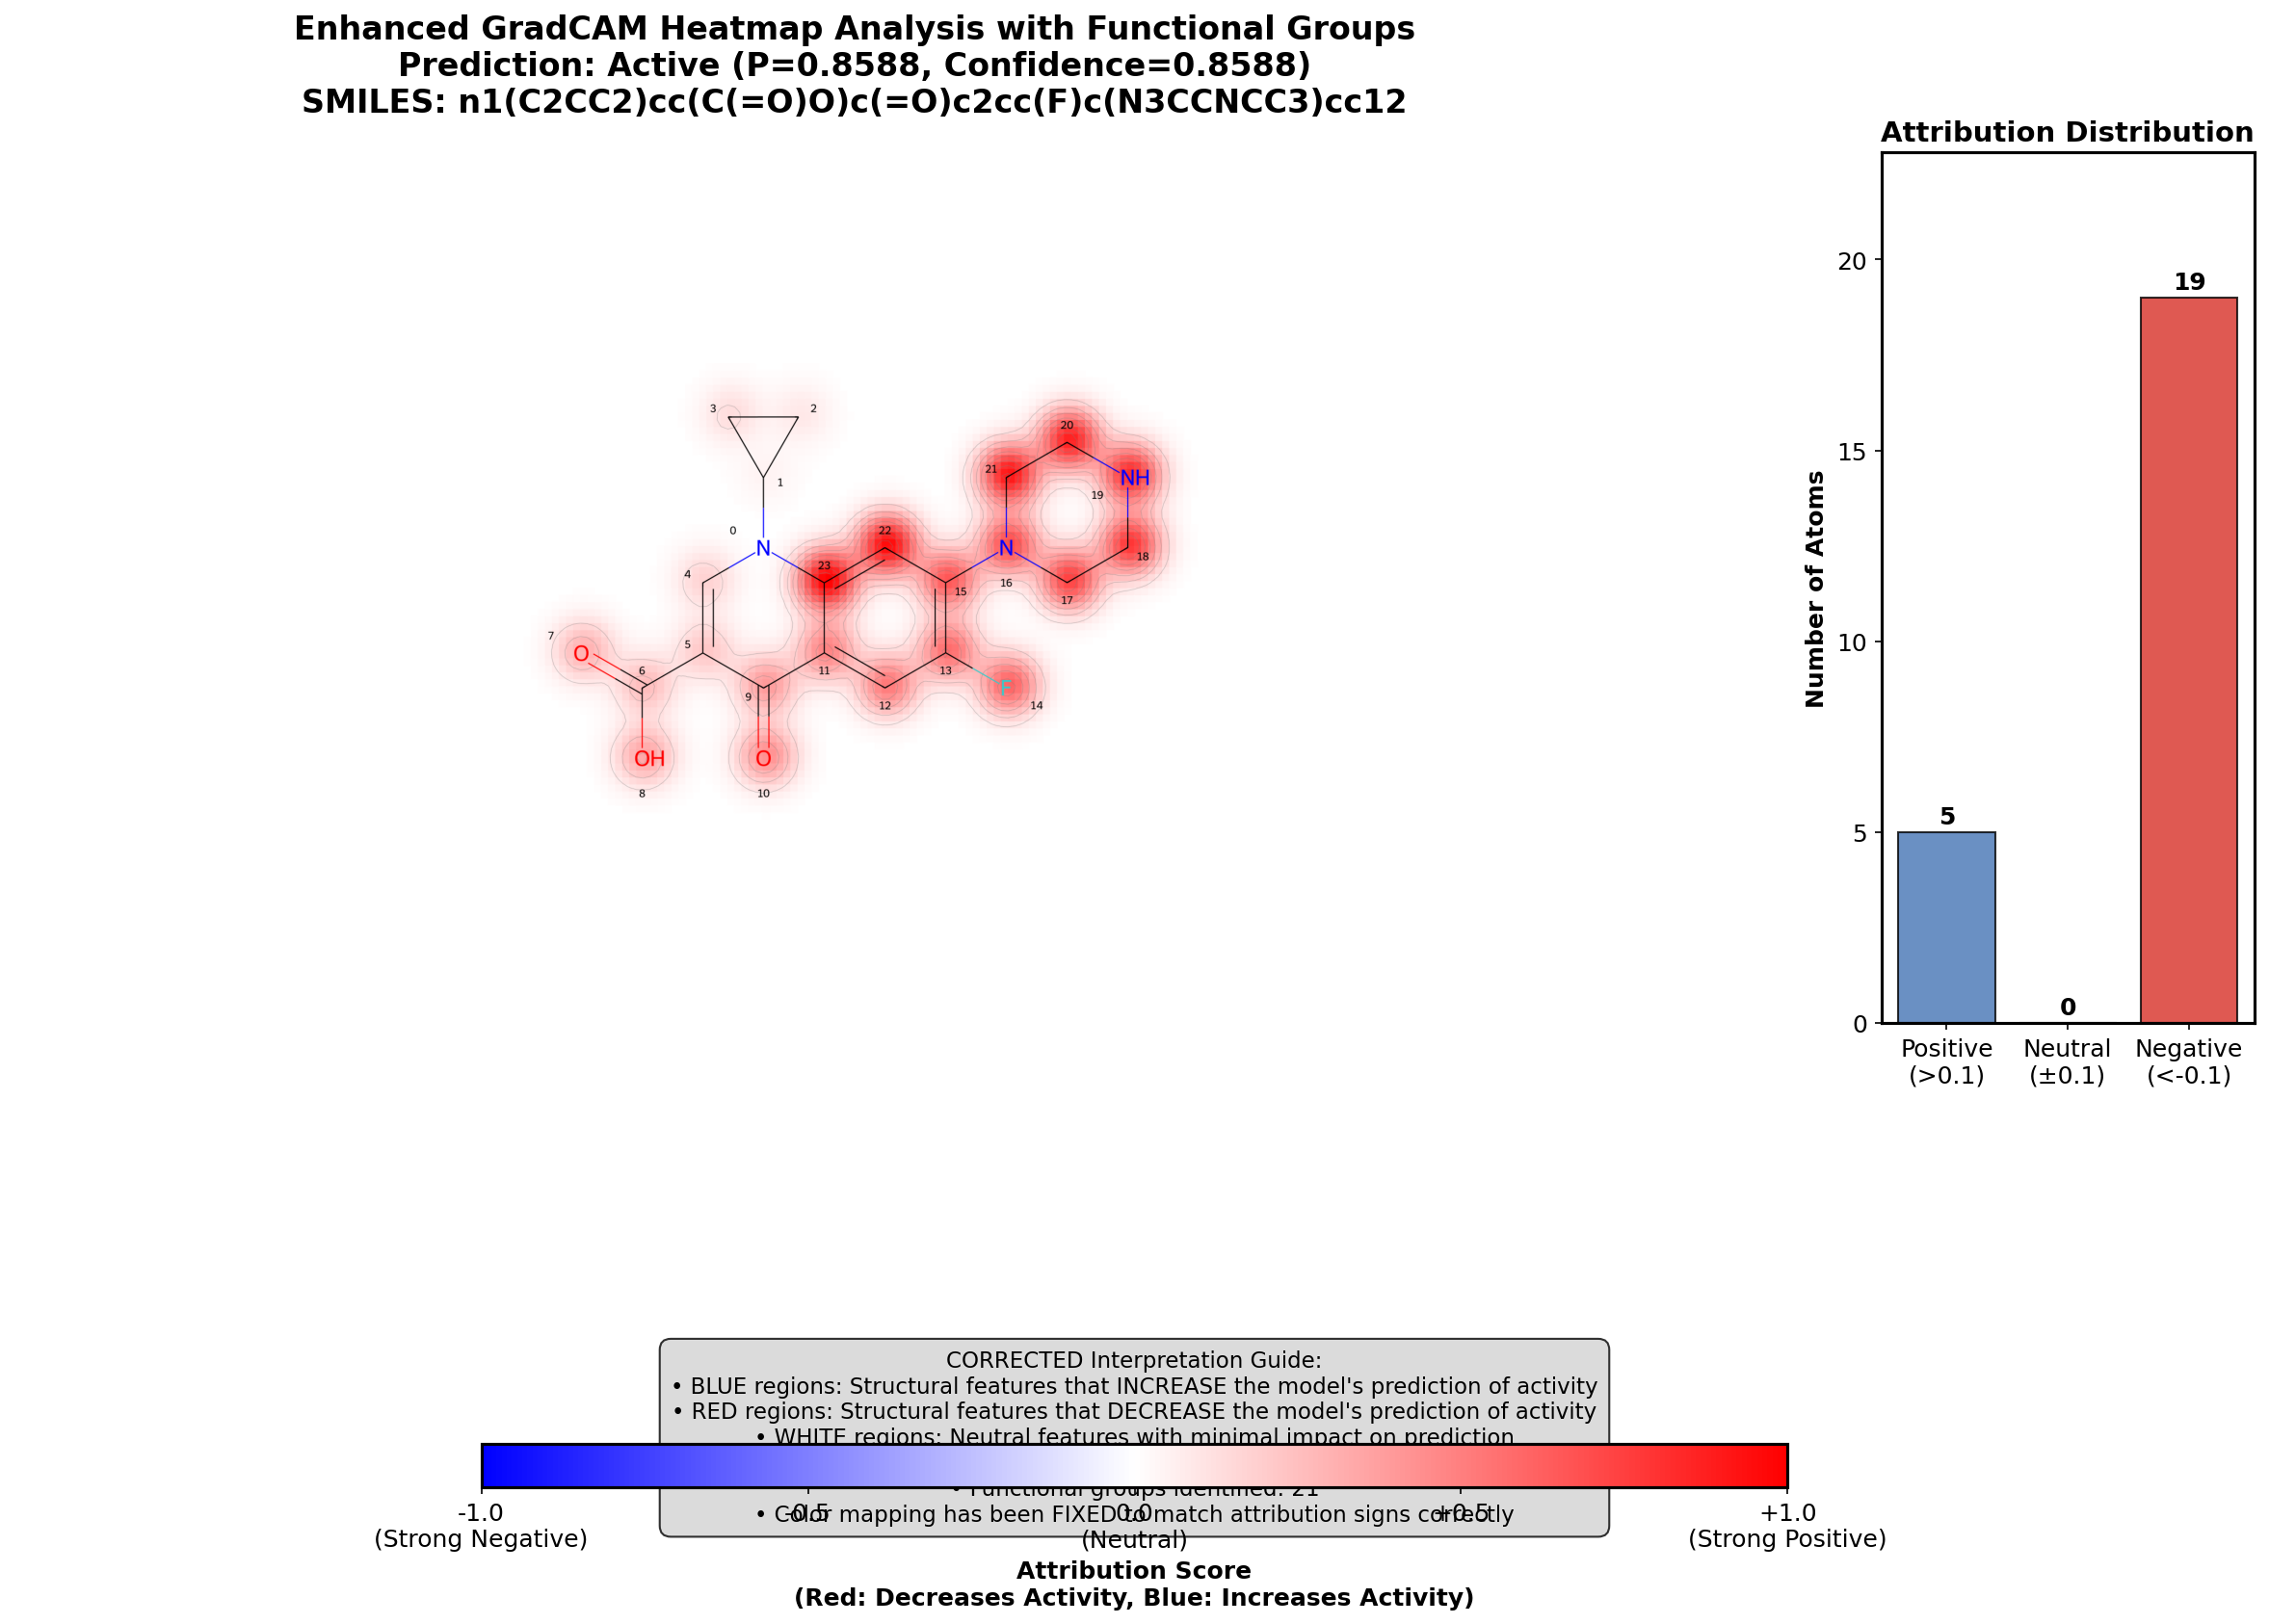


📋 ANALYSIS RESULTS:
   SMILES: n1(C2CC2)cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc12
   Probability of Active: 0.8588
   Predicted Class: Active
   Main image: gradcam_visualization_20250909_194255.png
   Comprehensive analysis: comprehensive_gradcam_analysis_20250909_194255.png
   CSV analysis: molecular_analysis_20250909_194255.csv

🎯 ANALYSIS COMPLETED in 3.67 seconds
📁 Main GradCAM heatmap: gradcam_results\gradcam_visualization_20250909_194255.png
📊 Comprehensive analysis figure and CSV also generated
💾 All results saved in 'gradcam_results' directory

🖼️  Displaying main molecular heatmap:


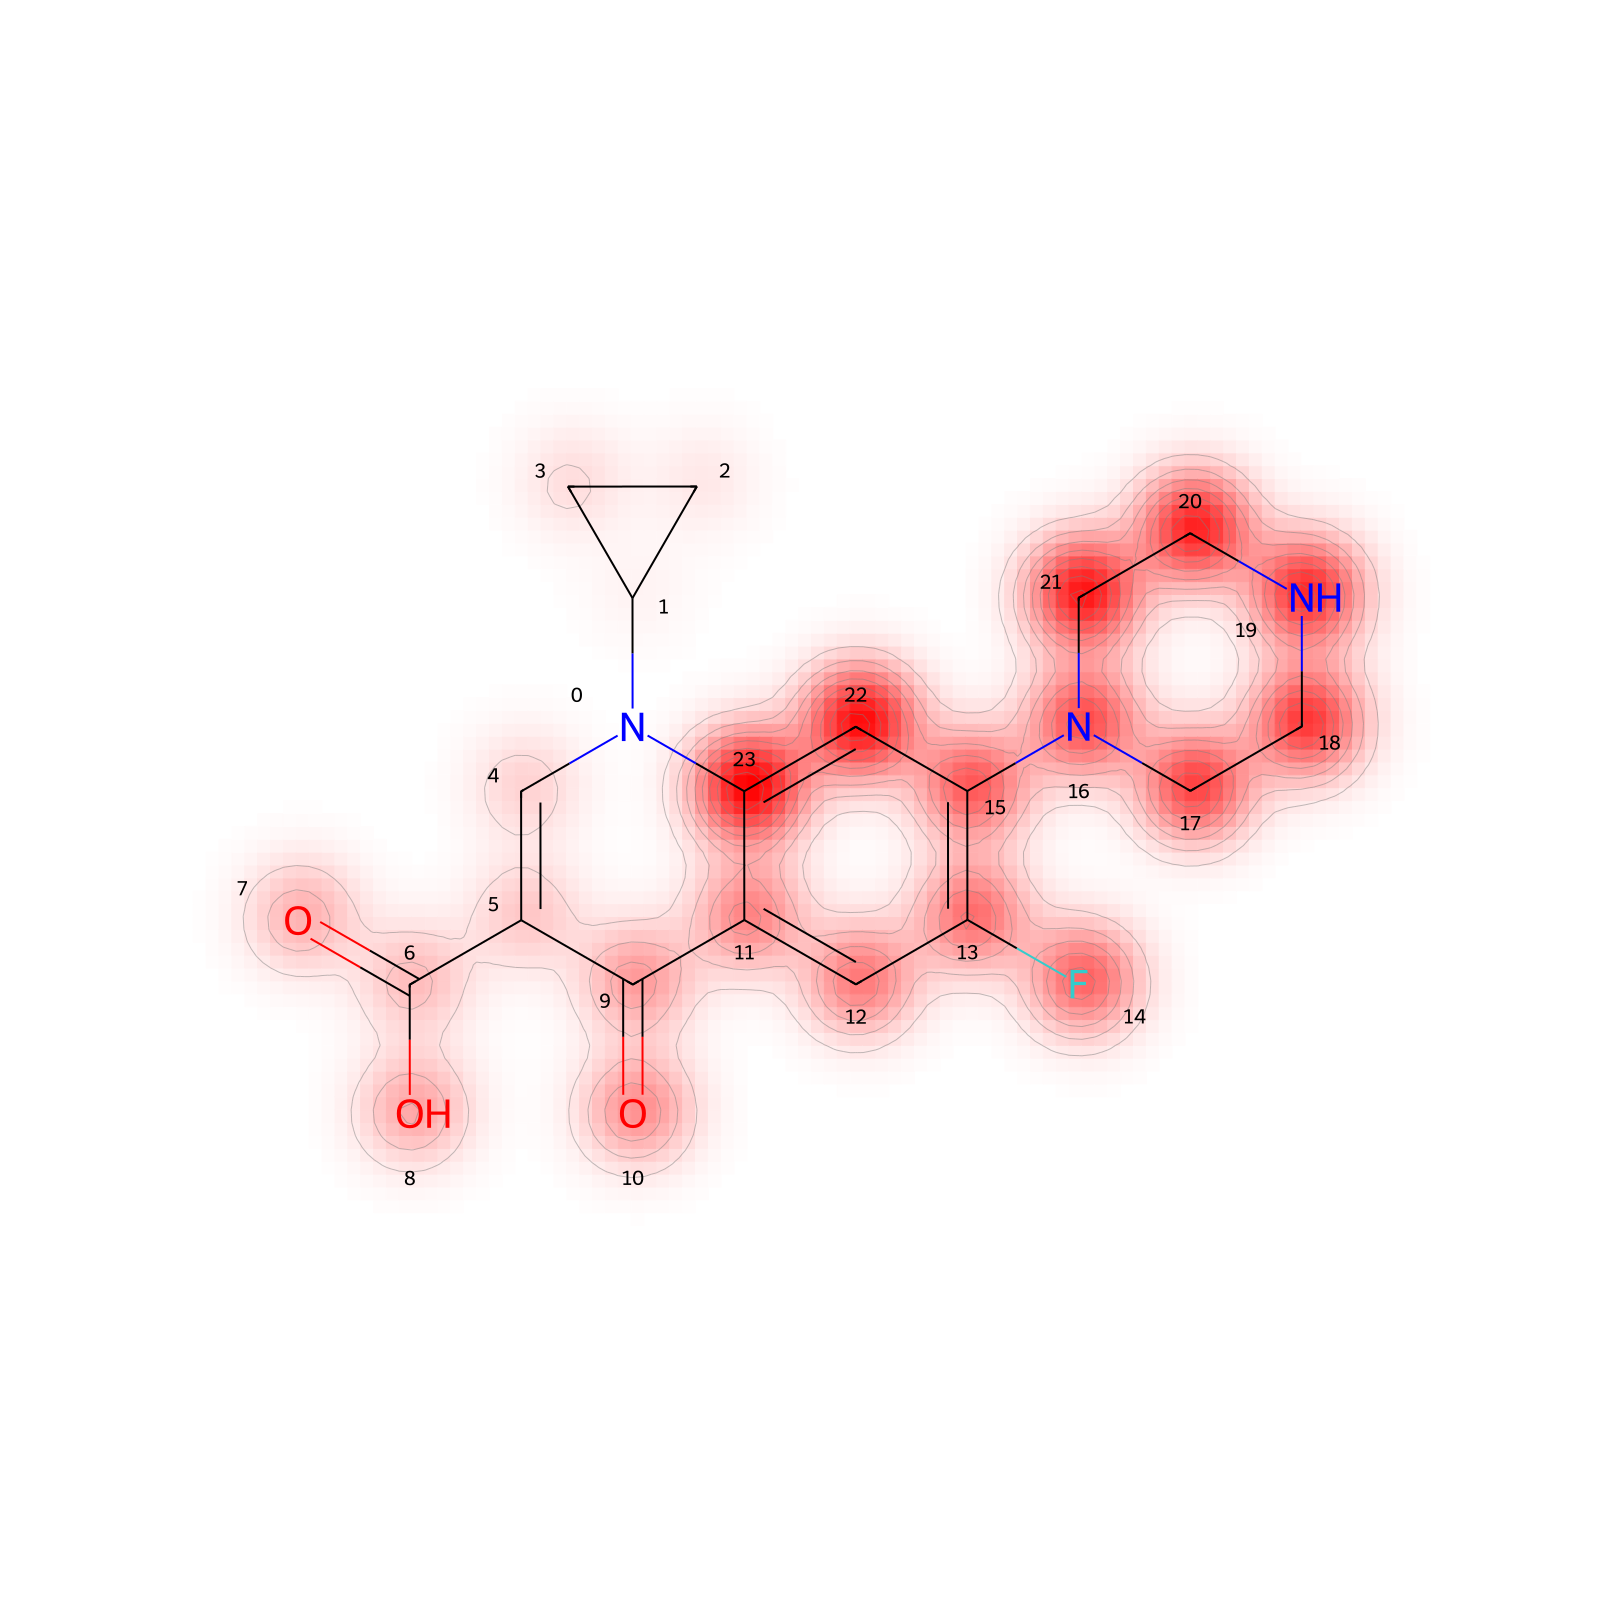


🔍 Check the console output above for:
   • Detailed functional group analysis
   • Molecular feature interpretation
   • Sign preservation diagnostics
   • CSV export location



In [18]:

smiles = 'n1(C2CC2)cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc12'  # ciprofloxacin 
#smiles = 'C1CC1n2cc(C(=O)O)c(=O)c3cc(F)c(N4CCNCC4)cc23' # ciprolfoxacin variant 
#smiles = 'O=C(O)c1cn(C2CC2)c3cc(N4CCNCC4)c(F)cc3c1=O' # ciprofloxacin variant 2 - active
#smiles ='FC1=C(C=C(N(C=C(C(OCC2=CC=C([N+]([O-])=O)C=C2)=O)C3=O)C4CC4)C3=C1)N5CCNCC5'  # prodrug 2 - 
#smiles = 'FC1=C(C=C(N(C=C(C(O)=O)C2=O)C3CC3)C2=C1)N4CCN(C(OCC5=CC=C(N=[N+]=[N-])C=C5)=O)CC4' # prodrug4


print("🎨 Testing ENHANCED CNN Attribution Analysis with Functional Groups...")
print("📊 Features: White background, sign preservation check, functional group analysis")
print("🔬 Molecular insights: CSV export, detailed interpretation, activity correlations")
print("\n" + "="*80)

# Check if enhanced ensemble is loaded
if 'ensemble' in locals() and hasattr(ensemble, 'visualize_gradcam'):
    print("✅ Enhanced ensemble with functional group analysis detected")
    
    # Analyze the molecule before visualization
    if RDKIT_AVAILABLE:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            print(f"🧪 Molecule Preview:")
            print(f"   Formula: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")
            print(f"   Molecular Weight: {Descriptors.MolWt(mol):.2f} g/mol")
            print(f"   Heavy Atoms: {mol.GetNumHeavyAtoms()}")
            print(f"   Rotatable Bonds: {Descriptors.NumRotatableBonds(mol)}")
            print(f"   Aromatic Rings: {Descriptors.NumAromaticRings(mol)}")
    
    print(f"\n🔄 Running Enhanced GradCAM Analysis...")
    start_time = time.time()
    image_path = ensemble.visualize_gradcam(smiles)
    analysis_time = time.time() - start_time
    
    if image_path:
        print(f"\n🎯 ANALYSIS COMPLETED in {analysis_time:.2f} seconds")
        print(f"📁 Main GradCAM heatmap: {image_path}")
        print(f"📊 Comprehensive analysis figure and CSV also generated")
        print(f"💾 All results saved in 'gradcam_results' directory")
        
        # Display the main image
        from IPython.display import Image as IPyImage, display
        print(f"\n🖼️  Displaying main molecular heatmap:")
        display(IPyImage(filename=image_path))
        
        print(f"\n🔍 Check the console output above for:")
        print(f"   • Detailed functional group analysis")
        print(f"   • Molecular feature interpretation") 
        print(f"   • Sign preservation diagnostics")
        print(f"   • CSV export location")
    else:
        print("❌ No image generated - check error messages above")
else:
    print("❌ Enhanced ensemble not found. Please run Cell 1 first.")
    available_objects = [name for name in locals() if not name.startswith('_')]
    print(f"Available objects: {available_objects}")

print("\n" + "="*80)